# Project: Gradients and Solvers

## Machine Learning, Fall 2021

### Name: William Yue

### Sources

#### Resources about matplotlib.pyplot:
* https://towardsdatascience.com/what-are-the-plt-and-ax-in-matplotlib-exactly-d2cf4bf164a9
* https://stackoverflow.com/questions/14432557/matplotlib-scatter-plot-with-different-text-at-each-data-point
* https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.annotate.html
* https://matplotlib.org/2.0.2/api/_as_gen/matplotlib.axes.Axes.plot.html
* https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.gca.html
* https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.contour.html

#### Resources for black box research
There's the three articles we were given:
* https://bdtechtalks.com/2020/07/27/black-box-ai-models/
* https://www.pewresearch.org/internet/2017/02/08/code-dependent-pros-and-cons-of-the-algorithm-age/
* https://towardsdatascience.com/machine-learning-algorithms-are-not-black-boxes-541ddaf760c3

As well as some I found independently: 
* https://hdsr.mitpress.mit.edu/pub/f9kuryi8/release/6
* https://www.nature.com/articles/s42256-019-0048-x

#### Resources for coding the Variable class:
* https://www.tutorialsteacher.com/python/magic-methods-in-python

#### Resources for coding the LinearRegression class:
* https://www.programiz.com/python-programming/methods/dictionary/update
* https://www.kite.com/python/answers/how-to-normalize-an-array-in-numpy-in-python
* https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html

#### Teammates:
* **Gradients and Contour Plots:** worked *independently*
* **Learning about the Black Box:** researched *independently*, but discussed with *Ali Yang* and *Arnav Bhakta*
* **The Variable Class:** worked with *Nathan Xiong*
* **The LogisticRegression Class:** worked with *Nathan Xiong* on `fit` function, coded rest *independently*
* For the Variable and LogisticRegression classes, I also discussed with *Ali Yang* and *Davin Jeong* several potential optimizations
* **Exploring the Black Box:** researched *independently*

In this project, you'll perform the following tasks:

1. [Explore gradients and contour plots](#Gradients-and-Contour-Plots),
2. [Learn about the notion of a "Blackbox" algorithm](#Learning-about-the-black-box)
2. [Define a `Variable` class](#The-Variable-class) which is used to compute the gradient of an "arbitrary" function,
3. [Test out your `Variable` class](#A-basic-test-of-your-Variable-class) by plotting some more gradients on contour plots, 
4. [Build and test a `LogisticRegression` class](#The-LogisticRegression-class) using your `Variable` class, and 
6. [Explore your fit model to ask questions about the black box](#Exploring-the-black-box)

In [1]:
# Standard import statements:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import colorama
from colorama import Fore

from sklearn.metrics import accuracy_score, confusion_matrix

%matplotlib inline

plt.style.use("ggplot")

## Gradients and Contour Plots

Let's begin by understanding how contour plots work.  These are 2D representations of functions of two variables (what some people might call "3D functions").  You may be familiar with [contour maps](http://sitesmedia.s3.amazonaws.com/creekconnections/files/2014/09/topomap.jpg); a contour map is simply a contour plot of the function 

$$f(\text{lattitude}, \text{longitude}) = \left<\text{height of the Earth's surface above sea level at that point}\right>.$$ 

More generally, the contours in a plot are the paths of same height.  Thus, traveling perpendicularly to a contour means traveling "straight up or down the mountain".  Here's a first attempt at making a contour plot for a function which somewhat resembles the top of a mountain:

Exception was raised: 
TypeError: Input z must be 2D, not 1D


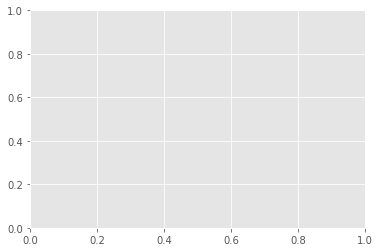

In [2]:
def f(x,y):
    return 1.2 - 0.2*x**2 - 0.3*y**2 + 0.1 * x * y - 0.25 * x

x = np.arange(-8,8,.1)
y = np.arange(-8,8,.1)


# maybe a first guess is:
z = f(x,y)
# print(len(x))
# print(len(y))
# print(len(z))

try:
    plt.contour(x, y, z);
except Exception as e:
    print("Exception was raised: \n", type(e).__name__, ": ", e, sep='')

That doesn't work, because this only plugs values into $f$ which are on the *diagonal*, that is, those values in the $xy$-plane where $x=y$. This is because $x$ and $y$ are numpy arrays so when they're passed into $f$, they get **manipulated componentwise**. In order to make this work, we need a function value over every point in our grid, i.e. every pair of $x$- and $y$-values in the square.  This is why the value for z must be 2D, because its indices `i` and `j` are the indices of its $x$- and $y$-values of its point.  That is, `z[i,j] = f(x[i], y[j])`.

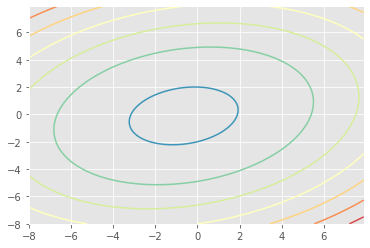

In [3]:
# Better, but super confusing. Try to parse this line:
z = np.array([[f(x[i],y[j]) for i in range(x.shape[0])] for j in range(y.shape[0])])

try:
    plt.contour(x, y, z, cmap='Spectral');
except Exception as e:
    print(e)

That works, but that line defining `z` sure was a slog.  This is where the helper function `np.meshgrid` comes into play:

In [4]:
X, Y = np.meshgrid(x, y)
Z = f(X,Y)

# print(X)
# print(Y)

# Convenience for printing 
iters = [('x', x), ('X', X), ('y', y), ('Y', Y), ('z', z) , ('Z', Z)]

for name, var in iters:
    print("The shape of {} is {}".format(name, var.shape))

if (z == Z).all():
    print("\nThese ways work the same")

The shape of x is (160,)
The shape of X is (160, 160)
The shape of y is (160,)
The shape of Y is (160, 160)
The shape of z is (160, 160)
The shape of Z is (160, 160)

These ways work the same


So `np.meshgrid` is used to build this `Z` (which is the same as our manually-built `z`).  But what are `X` and `Y`?

In [5]:
## Make sure you understand what the following code is doing!  It will help with understanding X and Y.

for name, var in iters[:4]:
    try:
        snipped = var[:6, :6]
    except:
        snipped = var[:6]
    print('Beginning of {}:\n{}'.format(name, snipped), end='\n\n')

Beginning of x:
[-8.  -7.9 -7.8 -7.7 -7.6 -7.5]

Beginning of X:
[[-8.  -7.9 -7.8 -7.7 -7.6 -7.5]
 [-8.  -7.9 -7.8 -7.7 -7.6 -7.5]
 [-8.  -7.9 -7.8 -7.7 -7.6 -7.5]
 [-8.  -7.9 -7.8 -7.7 -7.6 -7.5]
 [-8.  -7.9 -7.8 -7.7 -7.6 -7.5]
 [-8.  -7.9 -7.8 -7.7 -7.6 -7.5]]

Beginning of y:
[-8.  -7.9 -7.8 -7.7 -7.6 -7.5]

Beginning of Y:
[[-8.  -8.  -8.  -8.  -8.  -8. ]
 [-7.9 -7.9 -7.9 -7.9 -7.9 -7.9]
 [-7.8 -7.8 -7.8 -7.8 -7.8 -7.8]
 [-7.7 -7.7 -7.7 -7.7 -7.7 -7.7]
 [-7.6 -7.6 -7.6 -7.6 -7.6 -7.6]
 [-7.5 -7.5 -7.5 -7.5 -7.5 -7.5]]



<!-- <div style="background-color: #0c1444; padding: 10px"> -->
**Describe what you're seeing:**
<!-- </div> -->

`X` appears to be a two-dimensional numpy array whose rows consist of `x` repeated `len(y)` times. Meanwhile, `Y` appears to be a two-dimensional numpy array whose columns consist of `y` repeated `len(x)` times. Therefore, both arrays have `len(x)` columns and `len(y)` rows. The following code checks this.

In [6]:
x_test = [-1,1,5,6]
y_test= [2,3,4]
X_test, Y_test = np.meshgrid(x_test,y_test)

print(type(X_test),type(Y_test))
print(f'{X_test} has shape {X_test.shape}')
print(f'{Y_test} has shape {Y_test.shape}')

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
[[-1  1  5  6]
 [-1  1  5  6]
 [-1  1  5  6]] has shape (3, 4)
[[2 2 2 2]
 [3 3 3 3]
 [4 4 4 4]] has shape (3, 4)


There's a pretty simple way to explain what's going on here: consider a two-dimensional plot with the `x` values marked on the $x$-axis and the `y` values marked on the $y$ axis. Then, draw lines through the marked $x$-axis points parallel to the $y$-axis (marked in green below), as well as lines through the marked $y$-axis points parallel to the $x$-axis (marked in blue below). This results in a `len(y)` by `len(x)` array of points. Then, `X` is simply a numpy array of the $x$-values of this array of points, while `Y` is a numpy array of the $y$-values of this array of points. The following code draws this for `x_test`, `y_test`, `X_test`, and `Y_test`.

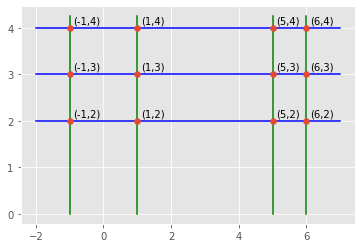

In [7]:
fig, ax = plt.subplots()

label_offset=0.1
ax.scatter(X_test,Y_test,zorder=2)
for x_value in x_test:
    for y_value in y_test:
        ax.annotate(f'({x_value},{y_value})',(x_value,y_value),
                    xytext=(x_value+label_offset,y_value+label_offset),zorder=2)

for x_value in x_test:
    ax.plot([x_value,x_value],[0,4.25],color='green',zorder=1)

for y_value in y_test:
    ax.plot([-2,7],[y_value,y_value],color='blue',zorder=1)
plt.show()

Notice that taking all the $x$-values of the red points together gives `X_test` (the exact order of values in `X_test` is given by the order of values in `x_test`), while taking all of the $y$-values of the red points together gives `Y_test` (the exact order of values in `Y_test` is given by the order of values in `y_test`).

Okay, so now that we know how to plot contour plots of functions of 2 variables, let's explore adding some **gradients** to the plot.  First we define a helper function, used to help us draw the arrows on contour plots.

In [8]:
def draw_arrow(a, b, c, d, ax=None):
    """ Draw an arrow on a plot.
    
    params:
        a, b -- coordinates of the base of the arrow
        c, d -- vector corresponding to the arrow (starting at the origin)
        ax   -- the matplotlib Axes object on which to draw the arrow.  If none, set to current Axes object.
    """
    ax = ax or plt.gca()
    v_0 = np.array([a,b])
    v_1 = np.array([c,d]) + v_0
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    color='k')
    plt.annotate('', v_1, v_0, arrowprops=arrowprops)

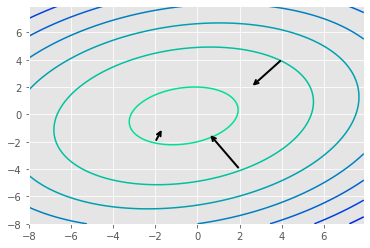

In [9]:
# Plot the contour plot as well as some gradient vectors
x = np.arange(-8,8,.1)
y = np.arange(-8,8,.1)

X, Y = np.meshgrid(x,y)
Z = f(X,Y)

plt.contour(x, y, Z, cmap='winter')

# Draw some gradients
draw_arrow(2, -4, -1.45,  2.6)
draw_arrow(-2, -2, 0.35, 1)
draw_arrow(4, 4, -1.45, -2)

<!-- <div style="background-color: #0c1444; padding: 10px;"> -->
<p> Okay, so now here's your task. The gradient of the above function happens to be:
$$\nabla f(x,y) = \left<-.4 x + .1 y - .25, -.6 y + .1 x\right>.$$ 

What this means is: at any point $(x, y)$, the gradient is a vector whose $x$- and $y$-components are given by the right-hand side of the equation. You don't need to know how to compute that gradient.
    
Create a function `draw_gradient` that, given a point $(x,y)$, draws the gradient of $f$ at that point.  Then, in the same cell below, recreate the above plot so that your `draw_gradient` method gets called for a handful of randomly-generated points (so that you can rerun the cell and get a new handful of gradient vectors drawn each time).</p>
<!-- </div> -->

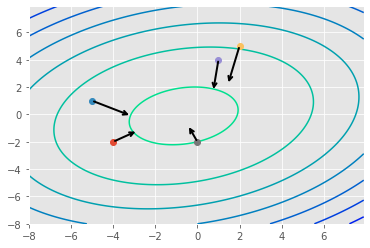

In [10]:
def draw_gradient(x,y,ax=None):
    ax = ax or plt.gca()
    draw_arrow(x,y,-0.4*x+0.1*y-0.25,-0.6*y+0.1*x,ax=ax)
    ax.plot(x,y,marker='o')

plt.contour(x, y, Z, cmap='winter')

num = 5

for _ in range(num):
    draw_gradient(np.random.randint(-6,6), np.random.randint(-6,6))

<!-- <div style="background-color: #0c1444; padding: 10px;"> -->

<h3> Rules for Gradients:</h3>

<p>As we have seen, the gradient is a function that points us "up the hill", in the direction of steepest increase of a function $f$.  What does that mean?  It's important to keep in mind that if you have a function $f$ then the gradient of $f$, written as $\nabla f$, is a different function that takes in points from the same space $f$ does and outputs a vector which points up toward the direction of steepest increase at that point.</p>

<p>Below are all the rules that we will need for our gradients.  In a multivariable calculus class, you would study and possibly even prove these statements.  For us, we'll take them as our programming requirements: the gradient is simply a recursive function with a bunch of rules.  <strong>Do not feel like you need to memorize these for my class, or understand where they come from. I will never ask you to compute the gradient of a function by hand.</strong></p>

<ul>
<li> If $x_i$ is the $i^{\text{th}}$ independent variable, then $\nabla x_i = \left<0,\ldots,0,1,0,\ldots, 0\right>$, where the $1$ is in the $i^{\text{th}}$ slot.  Another way to say this is the following.  Suppose my function $f$ just picked out the $i^{\text{th}}$ variable: $f(x_1, \ldots, x_p)=x_i$, for some $i$.  Then the gradient of $f$ would be length 1 and would point in the $x_i$-direction.</li>
<li> The gradient is <strong>linear</strong>: </li><ul>
 <li> If $f(x_1, \ldots, x_p) = w_1+w_2$, then $\nabla f = \nabla w_1 + \nabla w_2$, and </li>
 <li> If $f(x_1, \ldots, x_p) = c \cdot w$, then $\nabla f = c \cdot \nabla w$.</li>
 <li> (As an extension of the first point: if $f(x_1, \ldots, x_p) = \sum_{i=1}^n w_i$, then $\nabla f = \sum_{i=1}^n\nabla w_i$.)</li>
 </ul>
<li> The gradient has a <strong>power rule</strong>: </li>
 <ul>
 <li> If $f(x_1, \ldots, x_p) = w^n$ then $\nabla f = n w^{n-1} \cdot \nabla w$, </li>
 </ul>
<li> The gradient has a <strong>product rule</strong>: </li>
 <ul>
 <li> If $f(x_1, \ldots, x_p) = w_1\cdot w_2$ then $\nabla f = w_1 \cdot \nabla w_2 + w_2 \cdot \nabla w_1$,</li>
 </ul>
    <li> The gradient does have a <em>difference rule</em> and a <em>quotient rule</em>, but you can just define yours using the facts that $w_1 - w_2 = w_1 + (-1) \cdot w_2$ and $\dfrac{w_1}{w_2} = w_1 \cdot (w_2)^{-1}$, respectively.</li>
<li> The gradient has a <strong>chain rule</strong>, which manifests itself in the following ways (the only ones we'll need):</li>
 <ul>
 <li> If $f(x_1, \ldots, x_p) = e^w$ then $\nabla f = e^w \cdot \nabla w$,</li>
 <li> If $f(x_1, \ldots, x_p) = \ln(w)$ then $\nabla f = \frac{1}{w} \cdot \nabla w$, </li>
 <li> There are lots of others, but we won't need them for now. </li>
 </ul>
</ul>
<!-- </div> -->

# Learning about the black box

One of the most common conversation points written about machine learning, and artificial intelligence more generally, is the notion that machine learning algorithms are "black boxes". Roughly, this means that the programmer creates the code which _trains_ the algorithm, runs that training code, then has _no idea_ what's going on "inside the box" of their machine learning model. Another goal for you in this project is to gain a more nuanced understanding of this argument. I want you to do a little bit of research now, and then explore later, the following questions:

* What does it mean to say that the creator of a machine learning model "doesn't know what's going on inside their algorithm"? What don't they know? _(hint: it has to do with parameters.)_
* Do machine learning model creators truly have _no idea_ what happens in their models? Perhaps, by default they don't? Or, in practice, they don't? 

You can find whatever resources you want on this topic (and if you find a resource you especially like, _definitely_ share with us all!). Here are some articles for you to explore if you need some help.

* [The dangers of trusting black-box machine learning](https://bdtechtalks.com/2020/07/27/black-box-ai-models/), by Ben Dickson
* [Code-Dependent: Pros and Cons of the Algorithm Age](https://www.pewresearch.org/internet/2017/02/08/code-dependent-pros-and-cons-of-the-algorithm-age/), by Lee Rainie and Janna Anderson. This article is HUGE, and covers many conversations. The point we're looking for in here is the last one, "Theme 7: The need grows for algorithmic literacy, transparency and oversight".
* [Machine Learning Algorithms are Not Black Boxes](https://towardsdatascience.com/machine-learning-algorithms-are-not-black-boxes-541ddaf760c3), by Zach Monge. This explores neural networks, which we haven't covered yet, but for now, just know that they are very similar to linear and logistic regression, just with thousands of parameters instead of just a handful ($m$ and $b$, or in a multidimensional version, $m_1, m_2, \ldots, m_m$, and $b$).

<!-- <div style="background-color: #0c1444; padding: 10px;"> -->
Provide a reflection here about your findings.
<!-- </div> -->

As described in the article [The dangers of trusting black-box machine learning](https://bdtechtalks.com/2020/07/27/black-box-ai-models/), there are two notions of black box algorithms:
* Algorithms where the model is difficult for the programmer to understand what it's doing
* Algorithms which are proprietary

Do note that these two notions definitely aren't exclusive from each other: many proprietary black box algorithms are also very difficult for any one human to understand (e.g. how YouTube recommends videos). We will be focusing mostly on the first notion of black box, since we are thinking about *programmers/creators* of models.

When a programmer of a machine learning model "doesn't know what's going on inside their algorithm," it means that they don't know how the parameters come together to produce the result (e.g. an accurate prediction). A programmer probably knows the architecture of the model, as well as how the algorithm updates the parameters (or at least they have some sense of it applying backpropagation to move in the direction of decreasing training loss). In addition, when given a model, they can look at each individual node or layer and the associated mathematical operation and understand that completely. In the case of something like a deep neural network, however, the combination of many nodes and layers makes it extremely difficult to tell how exactly the desired result is produced. 

The analogy to a brain is evident: people might understand how individual neurons work, or even small clusters of neurons, but understanding how all the neurons work together to form conscious thought in the brain is impossible. While a neural network is obviously much much simpler than a brain, we have a similar problem of understanding complicated emergent phenomena from a vast number of smaller pieces. So while, no, creators don't actually have *no idea* what's going on, but understanding how all the small moving parts come together is virtually impossible for deep, complicated models.

Given that black box models are important for high stakes decisions (https://www.nature.com/articles/s42256-019-0048-x, https://bdtechtalks.com/2020/07/27/black-box-ai-models/), I believe that we should work towards making machine learning algorithms more intepretable and explainable, especially given that they can sometimes perform as well or almost as well in certain problem spaces (as in https://hdsr.mitpress.mit.edu/pub/f9kuryi8/release/6), and definitely in cases where humans need to interact, interpret, and make judgments on the decisions (e.g. a doctor interpreting a model's suggestion for treatment). In any case, increasing interpretability is also ethically beneficiail: we can be sure that our decisions are more fair/unbiased (for cases like criminal justice, determining loans, etc.).

At the very least, we should dispel the myth that explainability/interpretability are necessarily inversely correlated with accuracy. Indeed, sometimes models that are too complicated actually perform *worse* than appropriately complex models (in theory this shouldn't ever happen, but it does in practice).

However, it's probably unfair to say that *all* black box algorithms can be easily replaced, given that some extremely useful models like DNNs have pretty inherent black-box natures (https://arxiv.org/abs/2001.02522). Certain problem spaces (like computer vision) are very challenging and don't have simple, interpretable models that solve them. I think in these cases, it's impossible to understand them (unless humanity is near the level of, say, understanding how the brain and consciousness work), and it's fruitless to try to construct interpretable models. Nonetheless, methods of increasing explainability can be helpful.

## The <code class="h2-code">Variable</code> class

Your main task in the project is to make a `Variable` class.  The `Variable` class is a node in the computational graph.  It should have the following attributes and methods:

* an attribute `inputs`, a list that records which inputs the current `Variable` objects takes.  This could highly leverage your wengert list.
* an `__init__` method,
* an `eval_` method that allows you to evaluate the variable at a given value of the primitive variables,
* a `grad` method that will compute return the gradient at a given value.  Here, you should use a numpy array. This might sound scary, but the main reason is so that you can compute with them nicely, later (see my implementation of a `grad` method below).  For example, to do this for $f(x_1, x_2, x_3) = x_1$, that `Variable`'s gradient function should `return np.array([1,0,0])`
* appropriate methods/functionality to calculate the gradients and function evaluation for all the gradients defined above.
* _(Optional)_ I found it helpful to have a class attribute called `all_variables` which is a list that keeps track of all the Variable objects in the order of creation.  There are fancy technical definitions and requirements of such a list, technically called a _Wengert list_, but for you it could just be a list that holds all your `Variable` objects (so in the constructor, you should append `self` to the list). You definitely may not need this, but some people benefit from making it. 
 * If you do make this, you'll likely need a class method which resets the list to an empty list.  This allows you to redefine the expression each time you create a new computational graph. Google `@staticmethod` to see the notation.

As an example, if I were to say:

```
>>> x = Variable()
>>> y = Variable()
>>> z = x + y
```

This will create a new `Variable` class for `z`, and initialize it appropriately, and give it the ability to take its gradient.  The way we can implement this is by defining a *magic* method called `__add__`.  Magic methods in Python are what give it such a great, readable API.  Here's an example `__add__` method, based on how I set up my constructor.  Yours might be a little bit different:

```
    def __add__(self, other):
        """ Defines the functionality of the `+` operator. """
        if isinstance(other, (int, float)):
            """ The derivative of a constant is zero. """
            return Variable(inputs = [self],
                                evaluate = lambda *values: other + self.eval_(*values), 
                                grad = self.grad
                            )
        elif isinstance(other, Variable):
            """ The differential operator is linear. """
            return Variable(inputs = [self, other],
                                evaluate = lambda *values: self.eval_(*values) 
                                    + other.eval_(*values),
                                grad = lambda *values: self.grad(*values) 
                                    + other.grad(*values)
                           )
        else:
            return NotImplemented
```

See [this link](http://www.diveintopython3.net/special-method-names.html#acts-like-number) to learn about the magic methods you will need to implement.

The theory here is that you create the "ugly" `x.__add__(y)`-ish code once and only once, and then when you use the code later it's much more readable: `x + y`.  You'll need to do something like this for all the operations discussed above in the [gradients section](#-Rules-for-Gradients:).  The exception is for functions like `exp` and `log` (and if I wanted you to do other things, like `sin`, `cos`, `tan`, <i>etc.</i>).  Those will need to be class methods.  They should still return a new `Variable` object.  See below for the API that they should support.

Other methods you need to implement:

* While you do need to have an `evaluate` method, if you also implement the `__call__` method (make it just call `evaluate`) then you can replace code of the form `w.evaluate(4, 2, 8.5)` with `w(4, 2, 8.5)`, which is both cleaner and looks like function notation (which is desirable because the `w`'s really can be thought of as functions of the independent variables).
* You might want to implement the `__repr__` method so that you can print out your variables (as in, just `print(x)`).  It would be especially nice if printing out a `Variable` object gave you a graph traversal of its `inputs`.  It's okay here if it looks like a tree, _i.e._ nodes get repeated.  It would be a bit too much work to make the true graph visual happen.
* You will need to implement the methods `__radd__` and `__rmul__`, _etc._ that give your `__add__` and `__mul__` method more functionality.  This allows expressions like `2 + x` instead of always requiring that a user use the `Variable` object first: `x + 2`.  In your research, you may see `__iadd__` and `__imul__`, and those you _should_ skip.

Here are some resources that may help you along the way:
* A good explanation on [Automatic Differentiation](https://pdfs.semanticscholar.org/be3d/17df872d41465dabda2fc9a9a61394658a1a.pdf) (the name of this process).  It's probably _much_ more information than you need.
* There's always [Wikipedia](https://en.wikipedia.org/wiki/Automatic_differentiation).
* Another take on [operator overloading in Python](http://blog.teamtreehouse.com/operator-overloading-python).

## A "complete" collection of uses that demonstrates the API 
Suppose my function is: 

$$f(x_1, x_2, x_3) = e^{x_1 + {x_2}^2} + 3 \cdot \ln(27 - x_1\cdot x_2 \cdot x_3).$$

Then the following code would build and test my function. The first line might be different for you, depending on how you create the `exp` and `log` functions:

```
>>> from Variable import exp, log
>>> x_1 = Variable()
>>> x_2 = Variable()
>>> x_3 = Variable()
>>> z = exp(x_1 + x_2**2) + 3 * log(27 - x_1 * x_2 * x_3)
>>> # Evaluate the function at the point (x_1, x_2, x_3) = (3, 1, 7):
>>> z(3, 1, 7)
59.9734284408284
>>> # Determine the gradient of the function at the point (x_1, x_2, x_3) = (3, 1, 7):
>>> z.grad(3, 1, 7)
array([ 51.09815003,  98.69630007,  -1.5       ])
>>> print(x_1 + x_2**2)
+(
 1: <input 1>
 2: ^2(
  <input 2>
 )
)
```
Two notes: 
1. I had to do some pencil-and-paper math on that gradient, let me know if it's not what you got!
2. The print-out is optional, but helpful!  You can make it say whatever you want.  Here, I made it list the node type, then indent the inputs of that node by one, recursively.  It almost looks a bit like [prefix notation](https://en.wikipedia.org/wiki/Polish_notation).

## Some thoughts on coding process

* I recommend that you don't actually define the class in a single cell in this notebook.  It's going to get a bit big, and it's going to be difficult to work on it together if it's in a cell on a jupyter notebook.  I believe that a better strategy for designing this class is to have a Python file `variable.py`, located in the same folder as this notebook and opened in your favorite text editor that contains your `Variable` class, and then just rerun a cell like this to reimport it here after saving over there:

In [11]:
from variable import Variable

* Then, when you change something and want to check out how it works, just rerun the above cell.
* This also makes sharing code via something like github a lot easier!
* I _highly recommend_ you begin by making everything other than gradients work, and then add gradients afterward. It will be **much** easier to understand.
* I also _highly recommend_ that you make it take in one-dimensional data at first (so that the parameters are just $m$ and $b$), and then allow for multidimensional inputs. For top marks on this assignment, one would need to add in multidimensional support, but it is a bit confusing to do so, and you will get almost complete understanding of the assignment by starting with one dimension.

Let's test out our `variable.py` file!

In [12]:
x_1 = Variable(name="x_1")
x_2 = Variable(name="x_2")
x_3 = Variable(name="x_3")

z = Variable.exp(x_1 + x_2**2) + 3 * Variable.log(27 - x_1 * x_2 * x_3)
print(z({"x_1": 3, "x_2": 1, "x_3": 7}))
print(z.gradient({"x_1": 3, "x_2": 1, "x_3": 7}))

59.97342844082839
[51.09815003 98.69630007 -1.5       ]


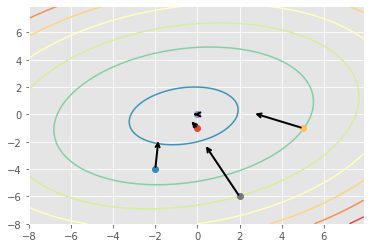

In [13]:
def f_gradient(x,y):
    return 1.2 - 0.2*x**2 - 0.3*y**2 + 0.1 * x * y - 0.25 * x

x_gradient = np.arange(-8,8,0.1)
y_gradient = np.arange(-8,8,0.1)

X_gradient, Y_gradient = np.meshgrid(x_gradient, y_gradient)
Z_gradient = f_gradient(X_gradient, Y_gradient)

plt.contour(x_gradient, y_gradient, Z_gradient, cmap='Spectral')

x = Variable(name="x")
y = Variable(name="y")
z = 1.2 - 0.2*x**2 - 0.3*y**2 + 0.1 * x * y - 0.25 * x

def draw_functional_gradient(x,y,ax=None):
    ax = ax or plt.gca()
    draw_arrow(x,y,*z.gradient({"x":x, "y":y}),ax=ax)
    ax.plot(x,y,marker='o')

# plot_pairs = [(0,0),(-2,2),(-4,-2)]

# for pair in plot_pairs:
#     draw_functional_gradient(pair[0], pair[1])
    
for _ in range(num):
    draw_functional_gradient(np.random.randint(-6,6), np.random.randint(-6,6))

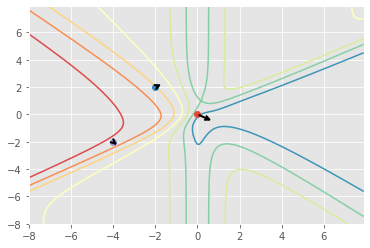

In [14]:
def f_gradient(x,y):
    return 1/(1+np.exp(-(x+y)))+1/(1+np.exp(-(2*x-3*y)))+1/(1+np.log(x**2+1))

x_gradient = np.arange(-8,8,0.1)
y_gradient = np.arange(-8,8,0.1)

X_gradient, Y_gradient = np.meshgrid(x_gradient, y_gradient)
Z_gradient = f_gradient(X_gradient, Y_gradient)

plt.contour(x_gradient, y_gradient, Z_gradient, cmap='Spectral')

x = Variable(name="x")
y = Variable(name="y")
z = 1/(1+Variable.exp(-1*x-y))+1/(1+Variable.exp(-2*x+3*y))+1/(1+Variable.log(x**2+1))

def draw_functional_gradient(x,y,ax=None):
    ax = ax or plt.gca()
    draw_arrow(x,y,*z.gradient({"x":x, "y":y}),ax=ax)
    ax.plot(x,y,marker='o')

plot_pairs = [(0,0),(-2,2),(-4,-2)]

for pair in plot_pairs:
    draw_functional_gradient(pair[0], pair[1])

All of this seems to be in perfect working order!

## The <code class="h2-code">LogisticRegression</code> class

Now that you have the class needed for creating a gradient, it's time to put it to use.  Construct a `LogisticRegression` class that serves as a logistic regression model.  It should support the standard Scikit-Learn API:

```
>>> X,y = <some dataset consisting numpy arrays in the standard form>
>>> model = LogisticRegression()
>>> model.fit(X, y)
>>> X_test, y_true = <some test dataset in the standard form>
>>> y_preds = model.predict(X_test)
>>> from sklearn.metrics import accuracy_score
>>> accuracy_score(y_true, y_preds)
```

Use your `Variable` class in the `fit` method of your class (or wherever else seems appropriate).  Remember, you're taking the gradient of the cost function, and the cost function has as its inputs the parameters of your model.  So you should have a `Variable` for every model parameter.  You **don't** need to support multi-class predictions (as in, you can assume your output variable `y` is binary), and it is **optional** to support a multidimensional `X` (as in, perhaps my dataset has 7 predictors, and I want to be able to use your class to fit my data).

You should fit your model to some data in order to (thoroughly!) test your model.

**Note**: I recognize that you could just take the partial derivatives (or google them), but that's not the point of this project!  The goal is to struggle through both creating _and_ using your `Variable` class.

I constructed the `LogisticRegression` class in the file `logistic_regression.py`, and it supports multidimensional `X`.

In [15]:
from logistic_regression import LogisticRegression

In [16]:
model = LogisticRegression()
model.fit([[1,1,1],[-1,-1,-1],[-2,-2,-2],[-2,-2,0],[0,-2,-2],[3,0,3]],[1,0,0,0,0,1], 0.1, 10000)
print(model.predict([[1,1,1],[3,0,2],[0,0,0],[-1,0,-1]]))

Loss: 3.7842782182742036
Step: [-0.66164379  4.3476178   3.41978714  4.48937118]
Current b: 0.02961413238574276
Current ms: [-0.43377566 -0.63248786 -0.30036182]
Loss: 0.0030720735457925464
Step: [0.00013259 0.00306392 0.00328532 0.00309899]
Current b: 0.12306474664944282
Current ms: [-2.10078277 -2.44129075 -2.0203192 ]
Loss: 0.0015634923680800236
Step: [7.56670542e-05 1.55896325e-03 1.65284212e-03 1.57313880e-03]
Current b: 0.11315352119130652
Current ms: [-2.31502891 -2.66969909 -2.23675457]
Loss: 0.0010509953442831455
Step: [5.22942043e-05 1.04801362e-03 1.10444676e-03 1.05634793e-03]
Current b: 0.10689416575672353
Current ms: [-2.44196599 -2.80386928 -2.36477168]
Loss: 0.0007923020823931245
Step: [3.97046353e-05 7.90128929e-04 8.29357440e-04 7.95843910e-04]
Current b: 0.10235005929532015
Current ms: [-2.5326423  -2.89923553 -2.45613588]
Loss: 0.0006361359082667959
Step: [3.18658323e-05 6.34449950e-04 6.63999329e-04 6.38714026e-04]
Current b: 0.09879931486684711
Current ms: [-2.603

Loss: 7.897342310821857
Step: [ 0.62284958 16.66054118]
Current b: -0.3612304851579924
Current ms: [-8.26303386]
Loss: 0.07545305183899012
Step: [-0.00786302  0.00174642]
Current b: 29.28608995086307
Current ms: [-6.53261458]
Loss: 0.052693368172689464
Step: [-0.00551377  0.00122485]
Current b: 32.561123613983085
Current ms: [-7.26008583]
Loss: 0.040422651156023386
Step: [-0.00424025  0.00094203]
Current b: 34.971726323593685
Current ms: [-7.7956132]
Loss: 0.03276263806790378
Step: [-0.00344234  0.00076481]
Current b: 36.878430024161624
Current ms: [-8.21922639]
Loss: 0.027531255081176563
Step: [-0.00289602  0.00064345]
Current b: 38.4550732375101
Current ms: [-8.56952518]
Loss: 0.02373401874532736
Step: [-0.00249873  0.00055519]
Current b: 39.79880637465848
Current ms: [-8.86808491]
Loss: 0.020853502863043827
Step: [-0.00219692  0.00048814]
Current b: 40.96942163596356
Current ms: [-9.1281858]
Loss: 0.018594152279379644
Step: [-0.00195992  0.00043549]
Current b: 42.00632751942697
Curr

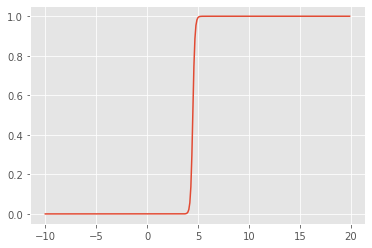

In [17]:
model_1var = LogisticRegression()
X = np.arange(10).reshape(10,1)
y = [0,0,0,0,0,1,1,1,1,1]
model_1var.fit(X,y,0.5,10000)

mesh = np.arange(-10,20,.1).reshape((-1,1))
p = model_1var.predict(mesh)
plt.plot(mesh, p)

plt.show()

Loss: 10.074428965723014
Step: [ 1.96561343 20.82134034]
Current b: -0.24236682926473035
Current ms: [-1.87163602]
Loss: 18.980409105262762
Step: [ -2.84029663 -12.3984625 ]
Current b: 4.070244985974727
Current ms: [-1.04383068]
Loss: 7.000914626529933
Step: [ 2.52609597 13.97337708]
Current b: 3.5509650119694687
Current ms: [-1.89312438]
Loss: 8.048907332890833
Step: [ 3.05251073 17.47518578]
Current b: 3.7196594925613344
Current ms: [-2.21600169]
Loss: 6.074466255109105
Step: [1.74499713 8.28379391]
Current b: 3.9607936511947917
Current ms: [-1.47192384]
Loss: 5.485037894900825
Step: [1.10423261 4.36663285]
Current b: 3.8350457222335486
Current ms: [-1.13111304]
Loss: 8.508952150430135
Step: [ 3.23751879 18.70912175]
Current b: 3.8121981114829153
Current ms: [-2.33327617]
Loss: 15.662468665864129
Step: [ -2.59292243 -11.87384979]
Current b: 4.119176253972274
Current ms: [-0.83976205]
Loss: 12.137965971389056
Step: [ -2.2624658  -11.03590123]
Current b: 4.050374695627669
Current ms: [

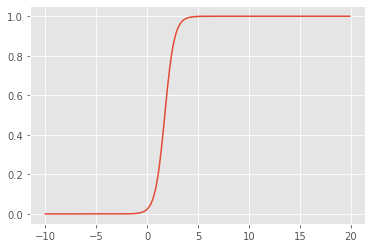

In [18]:
model_1var = LogisticRegression()
X = np.arange(10).reshape(10,1)
y = [0,0,0,1,0,1,1,0,1,1]
model_1var.fit(X,y,0.1,10000)

mesh = np.arange(-10,20,.1).reshape((-1,1))
p = model_1var.predict(mesh)
plt.plot(mesh, p)

plt.show()

In [19]:
def prediction_cutoff(x):
    return int(x > 0.5)

X_test = (np.arange(10)+0.1).reshape(10,1)
y_test = y
accuracy_score(y_test,list(map(prediction_cutoff,model_1var.predict(X_test))))

0.7

## Exploring the black box

Now that you've got a `Variable` class that lets you build a model, and you've created a model using it, I want you to revisit the notion of a "black box" algorithm. Obviously, our model is "small" in terms of its number of parameters, but I want you to look into your code, explore your model parameters, and "interpret" your fit model. What if you had to defend, say in court, a decision made by your model? Could you fully interpret and explain your model's decision? How? (Hint, just as before, it's the parameters.)

In [22]:
print(model.best_ms, model.best_b)

[-2.82428996 -3.2036003  -2.74960431] 0.08782182972297284


We can print out the parameters to the 3-feature model from above. This actually gives us a decent idea of what exactly the model is doing: the prediction is simply a sigmoid function applied to a linear combination of the weights above scaling the three inputs plus some bias. The weights here are scaled in a statistically optimal way to match the dataset (through repeated gradient descent in the `fit` fucntion), and they tell us precisely how much each factor matters towards the final decision. 

In this simple case, this would allow me to interpret what the model is doing when making a prediction and defend it, as it's a simple linear combination of inputs (also, note that changing the bias term should be equivalent to shifting where the cutoff is with respect to classification, as this will just pick different classification boundaries perpendicular to the vector of `m`s).